# Métricas de evaluación de la calidad de las imágenes de lesiones malignas generadas: SSIM y FID

En este notebook calculamos los valores de dos métricas de evaluación de la calidad para las imágenes de tipo maligno generadas por el modelo de difusión del melanoma de piel. Las métricas son el Similarity Structural Index (SSIM) y el Frechet Inception Distance (FID). Usamos la implementación de métricas de la librería `monai-generative` del [MONAI Project](https://github.com/Project-MONAI).

## Librerías necesarias

In [1]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights
from torch.cuda.amp import autocast

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

from generative.metrics import MultiScaleSSIMMetric, SSIMMetric
from generative.metrics import FIDMetric

## Parámetros

In [2]:
IMAGE_SIZE = 64
PIC_CHANNELS = 3
PIC_DIMENSION = 2
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

## Carga del modelo generador y sampleado de imágenes

Cargamos el modelo de difusión DDPM bidimensional ya entrenado, para que genere imágenes de lesiones de piel malignas (melanoma).

In [3]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(64, 128, 256, 256),
    attention_levels=(False, False, True, True),
    num_res_blocks=1,
    num_head_channels=256
)
model.to(device)

model.load_state_dict(torch.load('/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/MONAI Project/DDPM ISIC MONAI/prueba1/ddpm2d_hand_model.pt', map_location=device))

scheduler = DDPMScheduler(num_train_timesteps=1000)

inferer = DiffusionInferer(scheduler)

### Generación de imágenes

Sampleamos imágenes usando el modelo generativo cargado anteriomente.

In [4]:
model.eval()
generated_images = []
for i in range(100):
    n_synthetic_images = 5
    noise = torch.randn((n_synthetic_images, 3, IMAGE_SIZE, IMAGE_SIZE))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)
    with autocast(enabled=True):
        syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
    generated_images.append(syn_images)

syn_images = torch.cat(generated_images, dim=0)

/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1000/1000 [00:33<00:00, 29.86it/s]


Mostramos las cinco primeras imágenes generadas de cada tipo.

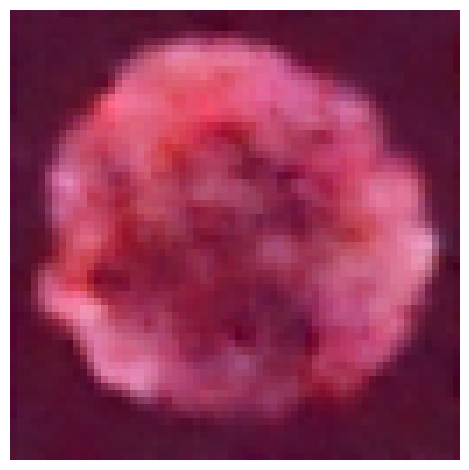

In [6]:
# Asumiendo que syn_images[0] es tu imagen de entrada
imagen = syn_images[0].cpu().permute(2, 1, 0).detach().numpy()

# Normalizar la imagen al rango [0, 1] para datos de tipo float
imagen_norm = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))

plt.imshow(imagen_norm)
plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Guardamos las imágenes generadas en un directorio
os.makedirs("synthetic_images", exist_ok=True)
for i, syn_image in enumerate(syn_images):
    syn_image = syn_image.cpu().permute(2, 1, 0).detach().numpy()
    syn_image = (syn_image - np.min(syn_image)) / (np.max(syn_image) - np.min(syn_image))
    plt.imsave(f"synthetic_images/synthetic_image_{i}.jpg", syn_image)

## Carga de las imágenes de entrenamiento (datos reales)

Cargamos las imágenes de entrenamiento de melanoma y hacemos las transformaciones necesarias para adaptarlas a las entradas de las redes preentrenadas.

In [3]:
# DATA_DIR = '/Users/alzorrcarri/skin_lesion_training_images'
DATA_DIR = r"D:\alzor\Documents\Dropbox\tfm\codigo\Métricas de evaluación\malignant\skin_lesion_training_images"

train_images = []
name_files = os.listdir(DATA_DIR)

for file in name_files:
    if file.endswith('.jpg'):
        image = os.path.join(DATA_DIR, file)
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        image = torch.transpose(image, 0, 2)
        train_images.append(image/255.0)

In [4]:
train_loader = torch.utils.data.DataLoader(train_images, batch_size=2, shuffle=True)

## Carga de las imágenes sintética generadas por el modelo

Cargamos las imágenes de melanoma de piel generadas anteriormente por el modelo DDPM.

In [5]:
# DATA_DIR = '/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/Métricas de evaluación/synthetic_images'
DATA_DIR = r"D:\alzor\Documents\Dropbox\tfm\codigo\Métricas de evaluación\malignant\synthetic_images"

syn_images = []
name_files = os.listdir(DATA_DIR)

for file in name_files:
    if file.endswith('.jpg'):
        image = os.path.join(DATA_DIR, file)
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        image = torch.transpose(image, 0, 2)
        syn_images.append(image/255.0)

In [6]:
syn_loader = torch.utils.data.DataLoader(syn_images, batch_size=2, shuffle=True)

In [7]:
len(train_images), len(syn_images)

(5768, 500)

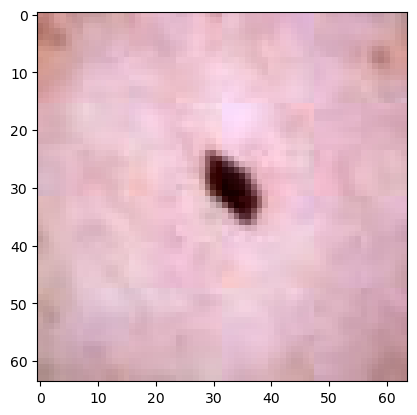

In [8]:
plt.imshow(train_images[0].permute(2, 1, 0))

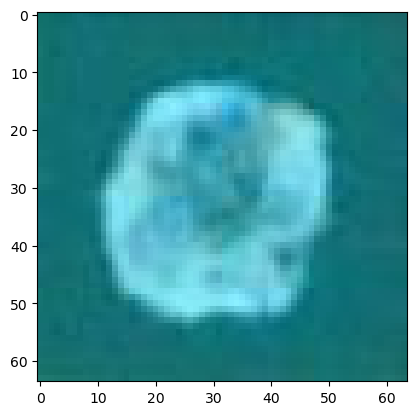

In [9]:
plt.imshow(syn_images[0].permute(2, 1, 0))

## Cálculo del SSIM y MS-SSIM

Calculamos el SSIM y MS-SSIM para cada uno de los tipos de imágenes reales y sintéticas. Esto lo haremos calculando dichas métricas para cada par de imágenes generadas y obteniendo el promedio de los valores obtenidos.

### Para el conjunto de imágenes sintéticas

In [10]:
ms_ssim_scores = [] # Para almacenar los valores de MS-SSIM y SSIM entre las imágenes generadas
ssim_scores = []

ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)

In [11]:
gen_images = torch.stack(syn_images).to(device)

In [18]:
gen_images.shape

torch.Size([500, 3, 64, 64])

In [12]:
# Se calculan el SSIM y el MS-SSIM entre todas las combinaciones posibles de pares de imágenes generadas
idx_pairs = list(combinations(range(len(gen_images)), 2))
for idx_a, idx_b in idx_pairs:
    ms_ssim_scores.append(ms_ssim(gen_images[[idx_a]], gen_images[[idx_b]]))
    ssim_scores.append(ssim(gen_images[[idx_a]], gen_images[[idx_b]]))

ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

In [13]:
# Mostramos la media y la desviación estándar de los valores de MS-SSIM y SSIM
print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.4f} +- {ms_ssim_scores.std():.4f}")
print(f"SSIM Metric: {ssim_scores.mean():.4f} +- {ssim_scores.std():.4f}")

MS-SSIM Metric: 0.3381 +- 0.2148
SSIM Metric: 0.5021 +- 0.1056


### Para el conjunto de imágenes reales

In [15]:
ms_ssim_scores = [] # Para almacenar los valores de MS-SSIM y SSIM entre las imágenes generadas
ssim_scores = []

ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)

In [16]:
real_images = torch.stack(train_images[0:500]).to(device)

In [17]:
real_images.shape

torch.Size([500, 3, 64, 64])

In [19]:
# Se calculan el SSIM y el MS-SSIM entre todas las combinaciones posibles de pares de imágenes generadas
idx_pairs = list(combinations(range(len(real_images)), 2))
for idx_a, idx_b in idx_pairs:
    ms_ssim_scores.append(ms_ssim(real_images[[idx_a]], real_images[[idx_b]]))
    ssim_scores.append(ssim(real_images[[idx_a]], real_images[[idx_b]]))

ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

In [20]:
# Mostramos la media y la desviación estándar de los valores de MS-SSIM y SSIM
print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.4f} +- {ms_ssim_scores.std():.4f}")
print(f"SSIM Metric: {ssim_scores.mean():.4f} +- {ssim_scores.std():.4f}")

MS-SSIM Metric: 0.2327 +- 0.1901
SSIM Metric: 0.4191 +- 0.1628


## Cálculo del FID

Calculamos el FID para el conjunto de imágenes generadas, comparando la distribución de características de dichas imágenes con las de un marco de referencia, que denominaremos como reales, que se obtiene del conjunto de imágenes de entrenamiento de ISIC usadas para los DDPM.

Las características de las imágenes se obtienen a través de una red neuronal preentrenada. En este caso, usaremos tres arquitecturas distintas: U-Net, ResNet50 y SkinLesNet.

### Cálculo del FID con U-Net

1. Cargamos la red preentrenada U-Net.

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, with_bn=False):
        super().__init__()
        if with_bn:
            self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
            )
        
    def forward(self, x):
        return self.step(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, with_bn=False):
        super().__init__()
        init_channels = 32
        self.out_channels = out_channels

        self.en_1 = DoubleConv(in_channels    , init_channels  , with_bn)
        self.en_2 = DoubleConv(1*init_channels, 2*init_channels, with_bn)
        self.en_3 = DoubleConv(2*init_channels, 4*init_channels, with_bn)
        self.en_4 = DoubleConv(4*init_channels, 8*init_channels, with_bn)
        
        self.de_1 = DoubleConv((4 + 8)*init_channels, 4*init_channels, with_bn)
        self.de_2 = DoubleConv((2 + 4)*init_channels, 2*init_channels, with_bn)
        self.de_3 = DoubleConv((1 + 2)*init_channels, 1*init_channels, with_bn)
        self.de_4 = nn.Conv2d(init_channels, out_channels, 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    def forward(self, x):
        e1 = self.en_1(x)
        e2 = self.en_2(self.maxpool(e1))
        e3 = self.en_3(self.maxpool(e2))
        e4 = self.en_4(self.maxpool(e3))
        
        d1 = self.de_1(torch.cat([self.upsample(e4), e3], dim=1))
        d2 = self.de_2(torch.cat([self.upsample(d1), e2], dim=1))
        d3 = self.de_3(torch.cat([self.upsample(d2), e1], dim=1))
        d4 = self.de_4(d3)

        if self.out_channels<2:
            return torch.sigmoid(d4)
        else:
            return torch.softmax(d4, 1)            

In [9]:
unet_original = UNet(3, 1, with_bn=True)
unet_original.load_state_dict(torch.load(os.path.join('/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/Redes/unet', 'unet_ISIC2016_trained.pth'), map_location=device))

<All keys matched successfully>

2. Creamos el extractor de características a partir de la red U-Net anterior quedándonos solo con el *Encoder* de la misma. Copiamos los valores de los parámetros para esta nueva red de la anterior.

In [10]:
class UNet_featextr(nn.Module):
    def __init__(self, in_channels, out_channels, with_bn=False):
        super().__init__()
        init_channels = 32
        self.out_channels = out_channels

        self.en_1 = DoubleConv(in_channels    , init_channels  , with_bn)
        self.en_2 = DoubleConv(1*init_channels, 2*init_channels, with_bn)
        self.en_3 = DoubleConv(2*init_channels, 4*init_channels, with_bn)
        self.en_4 = DoubleConv(4*init_channels, 8*init_channels, with_bn)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        e1 = self.en_1(x)
        e2 = self.en_2(self.maxpool(e1))
        e3 = self.en_3(self.maxpool(e2))
        e4 = self.en_4(self.maxpool(e3))
        
        return self.flatten(e4)  

In [11]:
unet_featextr = UNet_featextr(3, 1, with_bn=True)

# Cargamos los pesos del Encoder modelo pre-entrenado en el nuevo modelo
unet_featextr.en_1.load_state_dict(unet_original.en_1.state_dict())
unet_featextr.en_2.load_state_dict(unet_original.en_2.state_dict())
unet_featextr.en_3.load_state_dict(unet_original.en_3.state_dict())
unet_featextr.en_4.load_state_dict(unet_original.en_4.state_dict())

unet_featextr.to(device)
unet_featextr.eval()

UNet_featextr(
  (en_1): DoubleConv(
    (step): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (en_2): DoubleConv(
    (step): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (en_3): DoubleConv(
    (step): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [12]:
del unet_original
torch.mps.empty_cache()

3. Calculamos las características para cada una de las imágenes de train y sintéticas para la clase melanoma (`malignant`)

In [13]:
real_features = []
with torch.no_grad():
    for step, batch in enumerate(train_loader):
        real_images = batch.to(device)
        output = unet_featextr(real_images).to(torch.device('cpu'))
        real_features.append(output)

real_features = torch.vstack(real_features).float()

In [14]:
synth_features = []
with torch.no_grad():
    for step, batch in enumerate(syn_loader):
        syn_images = batch.to(device)
        output = unet_featextr(syn_images).to(torch.device("cpu"))
        synth_features.append(output)

synth_features = torch.vstack(synth_features).float()

In [15]:
synth_features.shape, real_features.shape

(torch.Size([500, 16384]), torch.Size([5768, 16384]))

4. Calculamos el FID

In [17]:
fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 2350.8118


### Cálculo del FID con SkinLesNet

Repetimos los pasos anteriores, pero esta vez con la arquitectura de red SkinLesNet.

In [8]:
class SkinLesNet(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(SkinLesNet, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 64)  # Adjusting for downsampling
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

In [9]:
skinlesnet = SkinLesNet(IMAGE_SIZE)
#skinlesnet.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/Redes/skinlesnet/ISIC/skinlesnet_trained.pth", map_location=device))
skinlesnet.load_state_dict(torch.load(r"D:\alzor\Documents\Dropbox\tfm\codigo\Redes\skinlesnet\ISIC\skinlesnet_trained.pth", map_location=device))

<All keys matched successfully>

Para el extractor de características eliminamos la última capa de la red, quedándonos con una salida de 64 valores para cada imagen, y copiamos los valores de los parámetros de la red preentrenada.

In [10]:
class SkinLesNet_featextr(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(SkinLesNet_featextr, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))  # Flatten the tensor
        
        return x

In [11]:
skinlesnet_featextr = SkinLesNet_featextr(IMAGE_SIZE)

# Copiamos los pesos del modelo pre-entrenado en el nuevo modelo
skinlesnet_featextr.conv1.load_state_dict(skinlesnet.conv1.state_dict())
skinlesnet_featextr.conv2.load_state_dict(skinlesnet.conv2.state_dict())
skinlesnet_featextr.conv3.load_state_dict(skinlesnet.conv3.state_dict())
skinlesnet_featextr.conv4.load_state_dict(skinlesnet.conv4.state_dict())

skinlesnet_featextr.to(device)
skinlesnet_featextr.eval()

SkinLesNet_featextr(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [ ]:
del skinlesnet

In [14]:
torch.cuda.empty_cache()

In [15]:
real_features = []
with torch.no_grad():
    for step, batch in enumerate(train_loader):
        real_images = batch.to(device)
        real_features.append(skinlesnet_featextr(real_images))

real_features = torch.vstack(real_features).to(torch.device("cpu"))

In [16]:
synth_features = []
with torch.no_grad():
    for step, batch in enumerate(syn_loader):
        syn_images = batch.to(device)
        synth_features.append(skinlesnet_featextr(syn_images))
        
synth_features = torch.vstack(synth_features).to(torch.device("cpu"))

In [17]:
real_features.shape, synth_features.shape

(torch.Size([5768, 2048]), torch.Size([500, 2048]))

In [18]:
fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 474.5047


### Cálculo del FID con ResNet50

In [8]:
resnet50_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [9]:
class New_ResNet50(nn.Module):
    def __init__(self, base_model):
        super(New_ResNet50, self).__init__()
        # Cargamos el modelo pre-entrenado con los parámetros congelados
        # Cambiamos la aquitectura de la capa fully-connected para que tenga 1024 neuronas
        self.base_model = base_model
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1024)

        # Descongelamos los parámetros de la capa fully-connected para que se actualicen durante el entrenamiento
        # ya que hemos cambiado su arquitectura
        for param in self.base_model.fc.parameters():
            param.requires_grad = True

        # Añadimos varias capas fully-connected para la clasificación
        # https://link.springer.com/article/10.1007/s00521-022-07793-2#Sec14
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return F.softmax(x, dim=1)

In [10]:
resnet50_model = New_ResNet50(resnet50_model).to(device)
resnet50_model.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/tfm/codigo/Redes/resnet50/ISIC/resnet50_trained.pth", map_location=device))

<All keys matched successfully>

In [11]:
class New_ResNet50_featextr(nn.Module):
    def __init__(self, base_model):
        super(New_ResNet50_featextr, self).__init__()
        # Cargamos el modelo pre-entrenado con los parámetros congelados
        # Cambiamos la aquitectura de la capa fully-connected para que tenga 1024 neuronas
        self.base_model = base_model
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1024)

        # Descongelamos los parámetros de la capa fully-connected para que se actualicen durante el entrenamiento
        # ya que hemos cambiado su arquitectura
        for param in self.base_model.fc.parameters():
            param.requires_grad = True

        # Añadimos varias capas fully-connected para la clasificación
        # https://link.springer.com/article/10.1007/s00521-022-07793-2#Sec14
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

    def forward(self, x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

In [12]:
resnet_featextr = New_ResNet50_featextr(resnet50_model.base_model)

# Copiamos los pesos del modelo pre-entrenado en el nuevo modelo
resnet_featextr.base_model.load_state_dict(resnet50_model.base_model.state_dict())
resnet_featextr.fc1.load_state_dict(resnet50_model.fc1.state_dict())
resnet_featextr.fc2.load_state_dict(resnet50_model.fc2.state_dict())
resnet_featextr.fc3.load_state_dict(resnet50_model.fc3.state_dict())
resnet_featextr.fc4.load_state_dict(resnet50_model.fc4.state_dict())

resnet_featextr.to(device)
resnet_featextr.eval()

New_ResNet50_featextr(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [13]:
del resnet50_model
torch.mps.empty_cache()

In [14]:
real_features = []
with torch.no_grad():
    for step, batch in enumerate(train_loader):
        real_images = batch.to(device)
        output = resnet_featextr(real_images).to(torch.device("cpu"))
        real_features.append(output)

real_features = torch.vstack(real_features)

In [15]:
synth_features = []
with torch.no_grad():
    for step, batch in enumerate(syn_loader):
        syn_images = batch.to(device)
        output = resnet_featextr(syn_images).to(torch.device("cpu"))
        synth_features.append(output)

synth_features = torch.vstack(synth_features)

In [16]:
fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 0.4878
